In [1]:
import pandas as pd
import base64
from io import BytesIO
from PIL import Image
import matplotlib.pyplot as plt
import random
import numpy as np


def parse_multi_choice_response(response, all_choices, index2ans):
    """
    Parse the prediction from the generated response.
    Return the predicted index e.g., A, B, C, D.
    """
    for char in [",", ".", "!", "?", ";", ":", "'"]:
        response = response.strip(char)
    response = " " + response + " "  # add space to avoid partial match

    index_ans = True
    ans_with_brack = False
    candidates = []
    for choice in all_choices:  # e.g., (A) (B) (C) (D)
        if f"({choice})" in response:
            candidates.append(choice)
            ans_with_brack = True

    if len(candidates) == 0:
        for choice in all_choices:  # e.g., A B C D
            if f" {choice} " in response:
                candidates.append(choice)

    # if all above doesn't get candidates, check if the content is larger than 5 tokens and try to parse the example
    if len(candidates) == 0 and len(response.split()) > 5:
        for index, ans in index2ans.items():
            if ans.lower() in response.lower():
                candidates.append(index)
                index_ans = False  # it's content ans.

    if len(candidates) == 0:  # still not get answer, randomly choose one.
        pred_index = random.choice(all_choices)
    elif len(candidates) > 1:
        start_indexes = []
        if index_ans:
            if ans_with_brack:
                for can in candidates:
                    index = response.rfind(f"({can})")
                    start_indexes.append(index)  # -1 will be ignored anyway
                # start_indexes = [generated_response.index(f'({can})') for can in candidates]
            else:
                for can in candidates:
                    index = response.rfind(f" {can} ")
                    start_indexes.append(index)
        else:
            for can in candidates:
                index = response.lower().rfind(index2ans[can].lower())
                start_indexes.append(index)
        # get the last one
        pred_index = candidates[np.argmax(start_indexes)]
    else:  # if only one candidate, use it.
        pred_index = candidates[0]

    return pred_index


# parse_multi_choice_response(
#     "So the correct answer is bbbbb.",
#     ["A", "B", "C", "D"],
#     {"A": "aaaaa", "B": "bbbbb", "C": "ccccc", "D": "ddddd"},
# )

def evaluate_accuracy(xlsx_file):
    data = pd.read_excel(xlsx_file).to_dict("records")
    accs = []
    for item in data:
        # if "choice_length" in item:
        #     all_choices = [chr(i) for i in range(65, 65 + item["choice_length"])]
        # else:
        all_choices = ["A", "B", "C", "D"]
        all_choices_mapping = {chr(i): str(item[chr(i)]) for i in range(65, 65 + len(all_choices))}
        pred_index = parse_multi_choice_response(str(item["prediction"]), all_choices, all_choices_mapping)

        accs.append(pred_index == item["answer"])

    return sum(accs) / len(accs)

# evaluate_accuracy("./yuchang_records_new/cambrian_8b/MathVista-357-MC_mc.xlsx")
# evaluate_accuracy("./yuchang_records_new/cambrian_8b/MMMU-1023-MC_mc.xlsx")

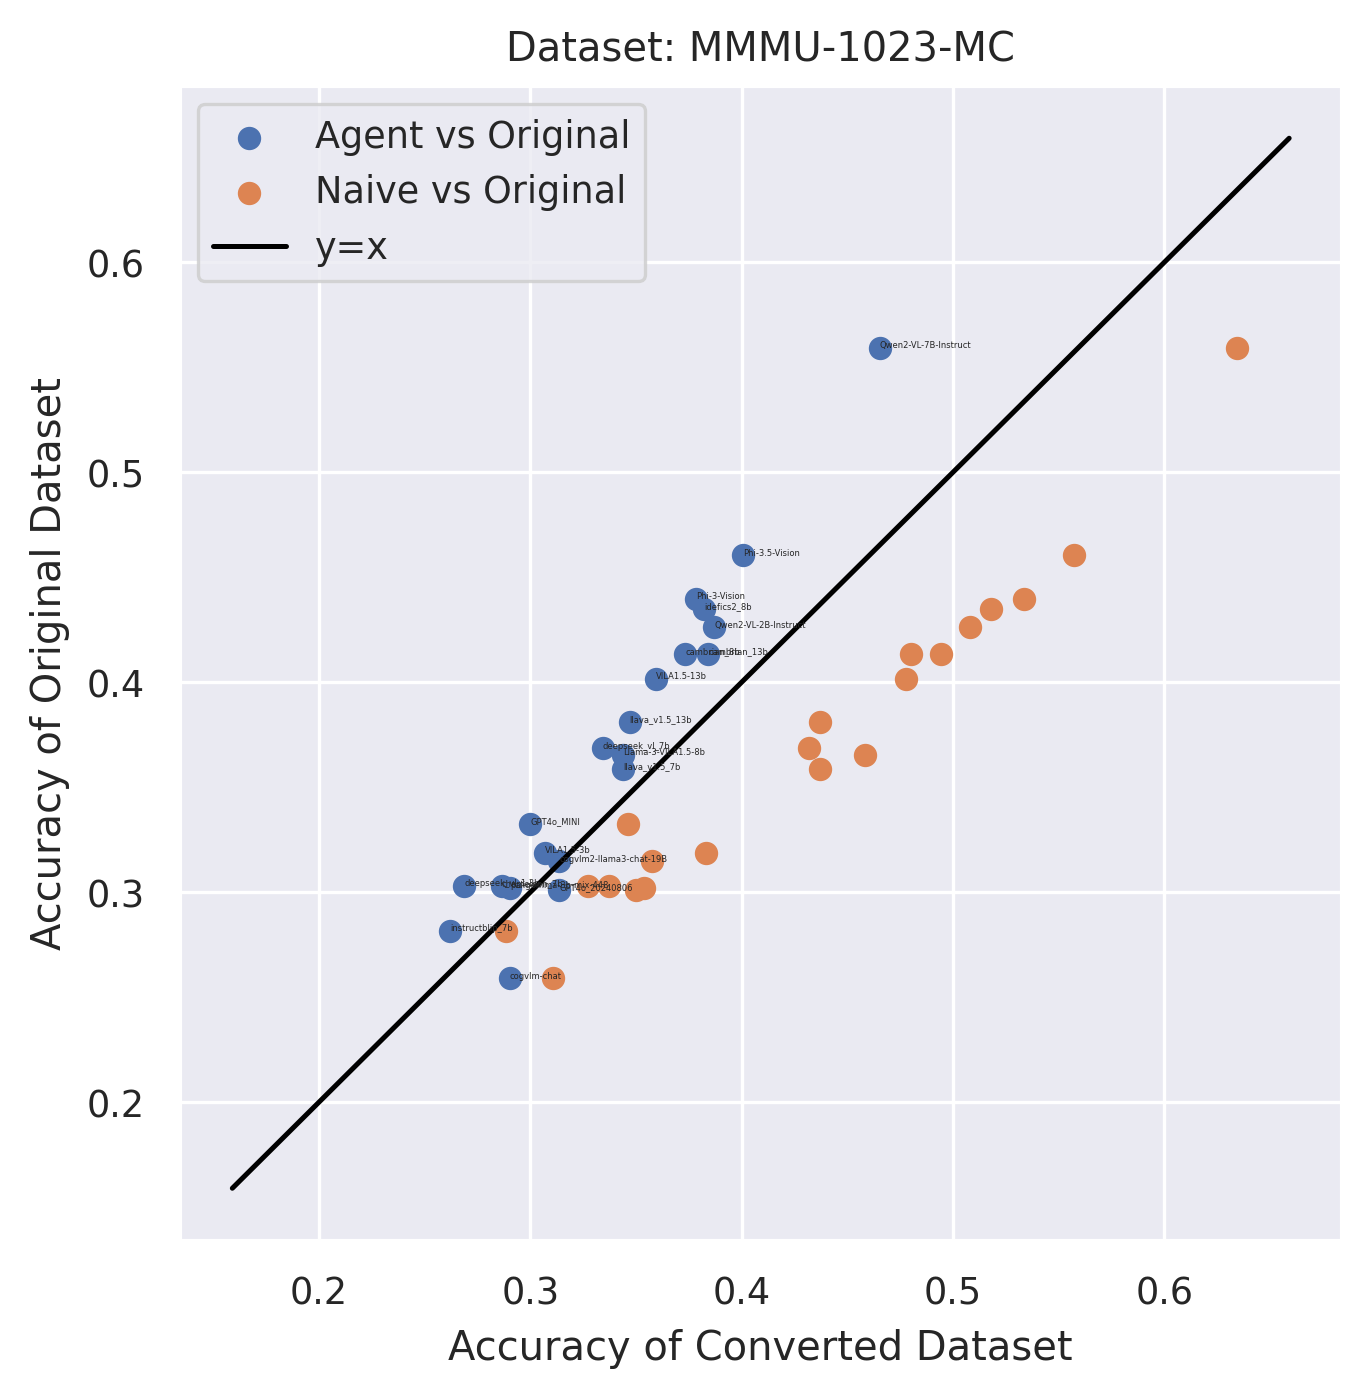

In [6]:
import os

models = sorted([dir for dir in os.listdir("./yuchang_records_new/") if ".csv" not in dir])

dataset = "MMMU-1023-MC"

model2acc = {}
for model in models:
    # xlsx_file_agent = f"./yuchang_records_new/{model}/{dataset}_mc.xlsx"
    # xlsx_file_original = f"./yuchang_records_new/{model}/{dataset}-OLD_mc.xlsx"
    # xlsx_file_baseline = f"./yuchang_records_new/{model}/{dataset}-4_mc.xlsx"

    xlsx_file_agent = f"./yuchang_records_new/{model}/{dataset}-1403_mc.xlsx"
    xlsx_file_original = f"./yuchang_records_new/{model}/{dataset}_mc.xlsx"
    xlsx_file_baseline = f"./yuchang_records_new/{model}/{dataset}-4-v0_mc.xlsx"
    if os.path.exists(xlsx_file_agent) and os.path.exists(xlsx_file_original) and os.path.exists(xlsx_file_baseline):
        acc_agent = evaluate_accuracy(xlsx_file_agent)
        acc_original = evaluate_accuracy(xlsx_file_original)
        acc_baseline = evaluate_accuracy(xlsx_file_baseline)
        model2acc[model] = {"acc_agent": acc_agent, "acc_original": acc_original, "acc_baseline": acc_baseline}

# draw a scatter plot to show acc_original (y-axis) vs acc_agent (x-axis) for each model
from matplotlib.axes import Axes
from matplotlib import pyplot as plt
import seaborn as sns

plt.rcParams["figure.dpi"] = 300
plt.rcParams["savefig.dpi"] = 300
sns.set_theme()
sns.set_context("paper")  # paper, notebook, talk, and poster

plt.figure(figsize=(5, 5))
plt.scatter(
    [v["acc_agent"] for v in model2acc.values()],
    [v["acc_original"] for v in model2acc.values()],
    label="Agent vs Original"
)

# draw the model name on the plot
for model, accs in model2acc.items():
    plt.text(accs["acc_agent"], accs["acc_original"], model, fontsize=2)

plt.scatter(
    [v["acc_baseline"] for v in model2acc.values()],
    [v["acc_original"] for v in model2acc.values()],
    label="Naive vs Original"
)

min_val = min([v["acc_original"] for v in model2acc.values()]) - 0.1
max_val = max([v["acc_original"] for v in model2acc.values()]) + 0.1

# draw y = x from min to max
plt.plot([min_val, max_val], [min_val, max_val], color="black", label="y=x")

plt.xlabel("Accuracy of Converted Dataset")
plt.ylabel("Accuracy of Original Dataset")
plt.title(f"Dataset: {dataset}")
plt.legend()
